In [12]:
import xgboost as xgb
import pandas as pd
import numpy as np
import os
import sys
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [13]:
df = pd.read_csv(os.path.join('../mimic/data_processed', 'mimic_dataset_incomplete.csv'))

In [14]:
# convert gender to 0 or 1
df['GENDER'] = (df['GENDER'] == 'M').astype(int)

In [15]:
def df_split(df, ratio=0.2):
    '''
    Given dataframe, split 20% of patients into a separate test dataframe.
    Return df_train, df_test
    '''
    num_hadms = len(df['HADM_ID'].unique())
    split = int(ratio * num_hadms)
    hadms = df['HADM_ID'].unique()[:split]
    
    return df[~df.HADM_ID.isin(hadms)], df[df.HADM_ID.isin(hadms)]

df_train, df_test = df_split(df)

In [16]:
X_cols = [
    "Creatinine", "HCO3", "HR", "Haemoglobin", "Platelet_count",
    "Potassium", "RR", "Sodium", "AGE", "GENDER",
    'Chronic Kidney Disease', 'Obesity', 'Heart disease', 'Asthma', #comorbidities
    'Weight_kg', 'SaO2'
]

In [17]:
df_test

,Creatinine,HCO3,HR,Haemoglobin,Platelet_count,Potassium,RR,Sodium,Weight_kg,SaO2,...,CHARTDATE,DAYS_TO_DISCH,AGE,GENDER,Day,DEATH,Chronic Kidney Disease,Obesity,Heart disease,Asthma
0,1.1,26.0,92.0,10.4,175.0,4.5,20.0,137.0,49.7,96.0,...,2188-05-25,6,56,1,1,0,0.0,0.0,0.0,0.0
1,1.2,23.0,89.0,10.2,175.0,4.8,12.0,134.0,49.7,97.0,...,2188-05-26,6,56,1,2,0,0.0,0.0,0.0,0.0
2,1.2,23.0,82.0,9.7,165.0,4.0,14.0,130.0,49.7,100.0,...,2188-05-27,6,56,1,3,0,0.0,0.0,0.0,0.0
3,1.1,24.0,74.0,10.3,166.0,4.0,11.0,136.0,49.7,100.0,...,2188-05-28,6,56,1,4,0,0.0,0.0,0.0,0.0
4,1.1,23.0,93.0,10.4,147.0,4.1,21.0,136.0,49.7,100.0,...,2188-05-29,6,56,1,5,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2839,4.1,30.0,50.0,10.1,170.0,4.2,20.0,138.0,87.0,98.0,...,2165-04-15,33,87,0,19,1,1.0,0.0,0.0,0.0
2840,3.4,30.0,65.0,9.8,145.0,4.3,22.0,141.0,87.0,97.0,...,2165-04-16,33,87,0,20,1,1.0,0.0,0.0,0.0
2841,2.8,28.0,70.0,8.6,158.0,4.1,28.0,138.0,87.0,96.0,...,2165-04-27,33,87,0,31,1,1.0,0.0,0.0,0.0
2842,3.5,26.0,70.0,8.5,164.0,4.4,14.0,140.0,87.0,98.0,...,2165-04-28,33,87,0,32,1,1.0,0.0,0.0,0.0


In [18]:
def create_tensors(df, maxshape=(0,0)):
    '''
    Split dataframe into X and Y tensors.

    Return X, Y
    '''
    hadms = df['HADM_ID'].unique()
    
    lst = []
    lst_y = []
    
    for hadm in hadms:
        point = df[df.HADM_ID == hadm][X_cols]
        
        # only use data points at least 48 hours
        if len(point) >= 2:
            point = point[:2]
            
        maxshape = max(maxshape, point.values.shape)
            
        lst.append(point.values)
        lst_y.append(df[df.HADM_ID == hadm]['DEATH'].iloc[0])
    
    # pad to max shape to create tensor
    ret = np.zeros((len(lst), *maxshape))
    
    ret_y = np.array(lst_y)
    
    for index, l in enumerate(lst):
        x, y = min(maxshape[0], l.shape[0]), l.shape[1]

        ret[index, :x, :y] = l[:x, :y]

    return lst, ret, ret_y

lst_train, X_train, Y_train = create_tensors(df_train)
lst_test, X_test, Y_test = create_tensors(df_test)

In [19]:
X_train.shape

(2312, 2, 16)

In [20]:
# flatten data down (both days into one row)
X_train = X_train.reshape(-1,32)
X_test = X_test.reshape(-1,32)

In [21]:
X_train.shape

(2312, 32)

In [23]:
parameters = {
    'max_depth' : range(3,10),
    'alpha' : range(1,20,2),
    'subsample' : [x / 10 for x in range(1, 11)],
    'colsample_bytree' : [x / 10 for x in range(1, 11)],
}

In [29]:
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate = 0.05, n_estimators = 1000),
                        param_grid = parameters, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)

In [30]:
gsearch1.fit(X_train, Y_train)

Fitting 5 folds for each of 7000 candidates, totalling 35000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 7176 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 8426 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 9776 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done 11226 tasks      

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.05, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constrai...
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': range(1, 20, 2),
                         'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
  

In [33]:
gsearch1.best_params_

{'alpha': 9, 'colsample_bytree': 0.4, 'max_depth': 8, 'subsample': 1.0}

In [42]:
gsearch1.best_score_

0.8382057387832743

In [51]:
xg = xgb.XGBClassifier(learning_rate=0.05, n_estimators=1000, alpha=9, colsample_bytree=0.4, max_depth=8, subsample=1)

In [52]:
xg.fit(X_train, Y_train)

XGBClassifier(alpha=9, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=9,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [53]:
# train accuracy
preds = xg.predict(X_train)
print(classification_report(Y_train, np.rint(preds).astype(int)))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1576
           1       0.87      0.76      0.81       736

    accuracy                           0.89      2312
   macro avg       0.88      0.85      0.87      2312
weighted avg       0.89      0.89      0.89      2312



In [54]:
# test accuracy
preds = xg.predict(X_test)
print(classification_report(Y_test, np.rint(preds).astype(int)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       408
           1       0.70      0.62      0.65       169

    accuracy                           0.81       577
   macro avg       0.77      0.75      0.76       577
weighted avg       0.80      0.81      0.81       577



In [55]:
np.rint(preds).astype(int)[np.argsort(Y_test)[::-1]]

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,

# SHAP

In [16]:
sys.path.append(os.path.join('..','..', 'shap'))
import shap as shap

In [17]:
# https://github.com/slundberg/shap/issues/1215
model_bytearray = xg.get_booster().save_raw()[4:]
def myfun(self=None):
    return model_bytearray

xg.get_booster().save_raw = myfun

In [34]:
explainer = shap.TreeExplainer(xg)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [35]:
xgb_shap = explainer.shap_values(X_test)

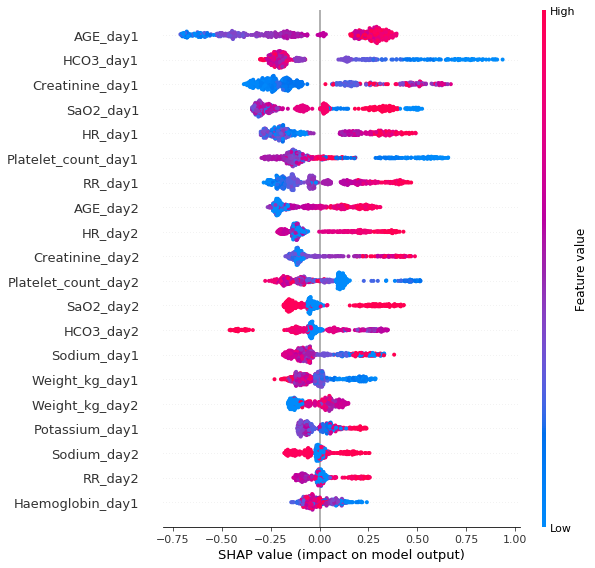

In [39]:
feature_names = [s + '_day1' for s in X_cols] + [s + '_day2' for s in X_cols]
shap.summary_plot(
    xgb_shap, X_test, feature_names=feature_names, plot_type="dot",
    auto_size_plot=False
)

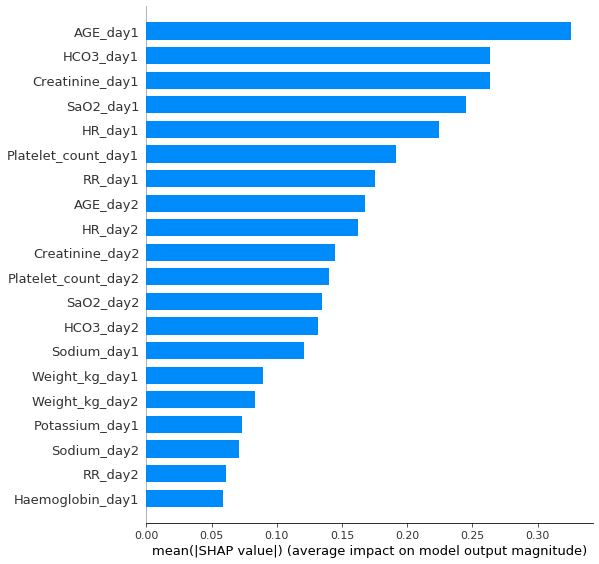

In [40]:
shap.summary_plot(
    xgb_shap, X_test, feature_names=feature_names, plot_type="bar",
    auto_size_plot=False, show=False
)

In [41]:
xgb_shap_interaction = explainer.shap_interaction_values(X_test)

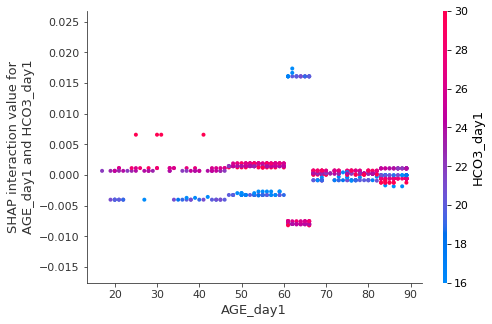

In [46]:
shap.dependence_plot(("AGE_day1", "HCO3_day1"), xgb_shap_interaction, X_test, feature_names=np.array(feature_names))